In [1]:
import numpy as np
import math
import random

# ---------------------------
# Global Seed
# ---------------------------
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# ---------------------------
# Problem Parameters
# ---------------------------
NUM_ROOMS = 10       # Number of hotel rooms
TIME_SLOTS = 24      # Number of time intervals in a day (e.g., 24 hours)
MIN_TEMP = 20.0      # Minimum allowed temperature (°C)
MAX_TEMP = 25.0      # Maximum allowed temperature (°C)
comfort_temp = 22.5  # Desired temperature when a room is occupied

# ---------------------------
# Environment Simulation Functions
# ---------------------------
def generate_outside_temperatures():
    """
    Simulate outside temperatures over the day using a sinusoidal pattern
    with added randomness. Peak temperature occurs around midday.
    
    Returns:
        np.array: Array of length TIME_SLOTS.
    """
    temps = np.empty(TIME_SLOTS)
    for t in range(TIME_SLOTS):
        # Sinusoidal pattern: average 20°C with amplitude 10°C, peak near noon
        temp = 20 + 10 * math.sin(2 * math.pi * (t - 6) / 24)
        # Add random fluctuation
        temp += random.uniform(-2, 2)
        temps[t] = temp
    return temps

def generate_door_open_schedule(prob_open=0.2):
    """
    Generate a schedule indicating whether a room's door is open at each time slot.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < prob_open)

def generate_orientation_factors():
    """
    Assign an orientation factor to each room based on its facing direction.
    For example, south-facing rooms might have a factor of 1.1 (more sun exposure),
    while north-facing rooms might have a factor of 0.9.
    
    Returns:
        np.array: Array of shape (NUM_ROOMS,) containing the factors.
    """
    orientations = ['north', 'south', 'east', 'west']
    factors = {'north': 0.9, 'south': 1.1, 'east': 1.0, 'west': 1.0}
    room_factors = np.array([factors[random.choice(orientations)] for _ in range(NUM_ROOMS)])
    return room_factors

def generate_occupancy_schedule(occupancy_prob=0.6):
    """
    Simulate an occupancy schedule where each room is occupied at a given time slot 
    with probability `occupancy_prob`.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < occupancy_prob)

def generate_price_schedule(month):
    """
    Generate a price schedule (EUR per energy unit) for each time slot based on the month.
    
    A simple simulation is used where:
      - Base price is 0.2 EUR/kWh.
      - Hourly variation is modeled with a sine pattern.
      - A month-based multiplier adjusts the cost (e.g., winter months cost more).
    
    Parameters:
        month (int): Month number (1-12).
        
    Returns:
        np.array: Array of length TIME_SLOTS with the price per energy unit.
    """
    base_price = 0.2  # Base EUR per kWh
    # Month factors: assume higher energy cost in winter, lower in summer.
    month_factors = {1: 1.2, 2: 1.2, 3: 1.1, 4: 1.0, 5: 0.9, 6: 0.9,
                     7: 0.8, 8: 0.8, 9: 0.9, 10: 1.0, 11: 1.1, 12: 1.2}
    m_factor = month_factors.get(month, 1.0)
    hours = np.arange(TIME_SLOTS)
    hourly_variation = 0.1 * np.sin(2 * math.pi * hours / TIME_SLOTS)
    price = (base_price + hourly_variation) * m_factor
    return price

# ---------------------------
# Global Precomputed Environment Data
# ---------------------------
outside_temps = generate_outside_temperatures()         # Shape: (TIME_SLOTS,)
door_open_schedule = generate_door_open_schedule(prob_open=0.2)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
orientation_factors = generate_orientation_factors()     # Shape: (NUM_ROOMS,)
occupancy_schedule = generate_occupancy_schedule(occupancy_prob=0.6)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
current_month = 1  # Example: January
price_schedule = generate_price_schedule(current_month)  # Shape: (TIME_SLOTS,)

# ---------------------------
# Chromosome & Random Solution Generation
# ---------------------------
def generate_random_solution():
    """
    Generates a random solution (chromosome) as a 1D NumPy array.
    
    Each gene is a temperature setpoint for a given room and time slot,
    uniformly sampled from [MIN_TEMP, MAX_TEMP].
    
    Returns:
        np.array: 1D array of length NUM_ROOMS * TIME_SLOTS.
    """
    return np.random.uniform(MIN_TEMP, MAX_TEMP, size=NUM_ROOMS * TIME_SLOTS)

# ---------------------------
# Fitness Function
# ---------------------------
def fitness(chromosome):
    """
    Calculate the fitness of a chromosome, expressed as the total money spent on energy (EUR).
    
    The fitness includes:
      1. **Energy Cost Calculation:**  
         - For each room and time slot, the energy consumption is determined by the difference
           between the setpoint and the outside temperature.
         - Heating is applied if the setpoint is above the outside temperature; cooling if below.
         - A base energy consumption is added.
         - Energy consumption is then adjusted using room orientation factors and door-opening events.
         - Finally, each hour's energy consumption is multiplied by a simulated hourly energy price.
         
      2. **Penalties:**  
         - **Temperature Range Violations:** A penalty of 1000 EUR per degree is added if any setpoint 
           falls outside the allowed range \([MIN\_TEMP, MAX\_TEMP]\).
         - **Occupancy Comfort:** When a room is occupied, a penalty of 50 EUR per degree deviation from the 
           desired comfort temperature is applied.
           
    The function is fully vectorized for efficiency.
    
    Parameters:
        chromosome (np.array): 1D array of length NUM_ROOMS * TIME_SLOTS.
        
    Returns:
        float: Total cost in EUR (lower is better).
    """
    # Reshape chromosome into 2D array (rooms x time slots)
    setpoints = chromosome.reshape((NUM_ROOMS, TIME_SLOTS))
    
    # --- Penalties ---
    # Temperature range violation penalty
    lower_violation = np.maximum(0, MIN_TEMP - setpoints)
    upper_violation = np.maximum(0, setpoints - MAX_TEMP)
    penalty_range = 1000 * (np.sum(lower_violation) + np.sum(upper_violation))
    
    # Occupancy comfort penalty (only apply where room is occupied)
    comfort_penalty = 50 * np.sum(np.abs(setpoints - comfort_temp) * occupancy_schedule)
    
    # --- Energy Consumption Calculation ---
    # Compute the difference between setpoint and outside temperature (broadcasting the outside_temps array)
    delta = setpoints - outside_temps  # Shape: (NUM_ROOMS, TIME_SLOTS)
    
    # Calculate energy consumption:
    #   - For heating (delta > 0): energy = delta * 1.5
    #   - For cooling (delta <= 0): energy = (-delta) * 1.2
    energy_consumption = np.where(delta > 0, delta * 1.5, -delta * 1.2)
    # Add a fixed base consumption per room per time slot
    energy_consumption += 0.5
    
    # Adjust consumption for room orientation (broadcast orientation factors)
    energy_consumption *= orientation_factors[:, np.newaxis]
    
    # Adjust for door opening events: multiply by 1.1 if door is open
    door_factor = np.where(door_open_schedule, 1.1, 1.0)
    energy_consumption *= door_factor
    
    # --- Cost Calculation ---
    # Multiply the energy consumption by the hourly price for each time slot (price_schedule broadcasts)
    cost_matrix = energy_consumption * price_schedule
    total_energy_cost = np.sum(cost_matrix)
    
    # Total fitness = energy cost + penalties
    total_cost = total_energy_cost + penalty_range + comfort_penalty
    return total_cost

# ---------------------------
# Example Usage
# ---------------------------
if __name__ == "__main__":
    # Generate a random solution (chromosome) as a 1D array.
    solution = generate_random_solution()
    
    # Evaluate its fitness (total energy cost in EUR)
    cost = fitness(solution)
    print("Fitness (Total Energy Cost in EUR) of a random solution:", cost)
    # Use the same initial solution for consistency
    init_solution = generate_random_solution()


Fitness (Total Energy Cost in EUR) of a random solution: 9256.071614675717


In [2]:
import json
from tqdm import tqdm

def random_search(num_iterations=100000, verbose=False):
    """
    Performs a random search by generating a specified number of random solutions,
    evaluates their fitness, and returns the best solution along with its fitness
    in JSON format.

    Parameters:
        num_iterations (int): The number of random solutions to generate.
        verbose (bool): If True, display a progress bar using tqdm. Defaults to False.

    Returns:
        str: A JSON string with the best chromosome (as a list) and its fitness.
             Example:
             {
                 "chromosome": [23.45, 21.67, ...],
                 "fitness": 1234.56
             }
    """
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

    best_fitness = float('inf')
    best_solution = None

    # Choose the appropriate iterator based on verbosity
    iterator = tqdm(range(num_iterations), desc="Random Search") if verbose else range(num_iterations)
    
    for _ in iterator:
        # Generate a random solution (chromosome) as a 1D array
        solution = generate_random_solution()
        # Evaluate its fitness (total energy cost in EUR)
        sol_fitness = fitness(solution)
        # Keep track of the best solution found so far
        if sol_fitness < best_fitness:
            best_fitness = sol_fitness
            best_solution = solution

    return best_solution.tolist(), best_fitness

# Run the random search with tqdm progress bar
best_sol, best_fit = random_search(100000 , verbose=True)

print("Best Fitness:", best_fit)


Random Search: 100%|██████████| 100000/100000 [00:02<00:00, 38511.40it/s]

Best Fitness: 7245.930399349862


Iterations: 500 | Best Fitness: 7960.29 EUR | Time: 0.01 s
Iterations: 1000 | Best Fitness: 7960.29 EUR | Time: 0.03 s
Iterations: 5000 | Best Fitness: 7678.98 EUR | Time: 0.12 s
Iterations: 10000 | Best Fitness: 7565.05 EUR | Time: 0.24 s
Iterations: 50000 | Best Fitness: 7299.48 EUR | Time: 1.16 s
Iterations: 100000 | Best Fitness: 7245.93 EUR | Time: 2.33 s
Iterations: 500000 | Best Fitness: 7161.46 EUR | Time: 11.79 s


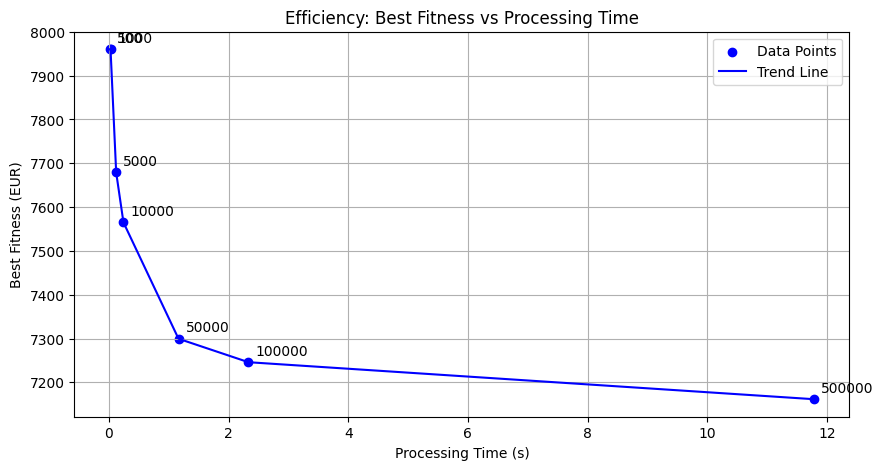

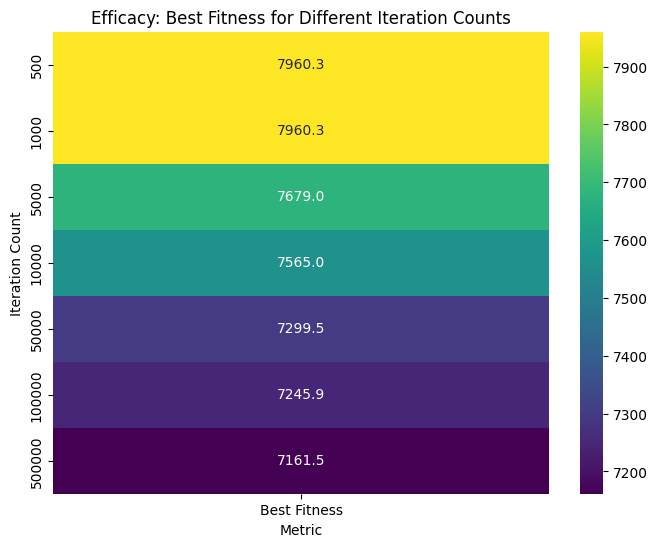

In [15]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_efficiency(iteration_counts, times, fitnesses):
    """
    Plots an efficiency graph where processing time (x-axis) and best fitness (y-axis)
    are connected by a line to show the trend across different iteration counts.
    """
    plt.figure(figsize=(10, 5))
    # Plot scatter points
    plt.scatter(times, fitnesses, color='blue', label='Data Points')
    # Connect points with a line to show the tendency
    plt.plot(times, fitnesses, color='blue', linestyle='-', label='Trend Line')
    
    # Annotate each point with the corresponding iteration count
    for i, n in enumerate(iteration_counts):
        plt.annotate(str(n), (times[i], fitnesses[i]), textcoords="offset points", xytext=(5,5))
    
    plt.xlabel("Processing Time (s)")
    plt.ylabel("Best Fitness (EUR)")
    plt.title("Efficiency: Best Fitness vs Processing Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the iteration counts to test.
iteration_counts = [500, 1000, 5000, 10000, 50000, 100000, 500000]

# Lists to hold the results for the efficiency plot.
times = []        # Processing time (s) for each iteration count.
fitnesses = []    # Best fitness achieved for each iteration count.

# Run a single random search for each iteration count.
for n in iteration_counts:
    start = time.time()
    best_result_json = random_search(n)
    best_result = json.loads(best_result_json)
    elapsed = time.time() - start

    times.append(elapsed)
    fitnesses.append(best_result["fitness"])
    print(f"Iterations: {n} | Best Fitness: {best_result['fitness']:.2f} EUR | Time: {elapsed:.2f} s")

# Plot Efficiency: Best Fitness vs Processing Time with tendency line
plot_efficiency(iteration_counts, times, fitnesses)

# --- Plot 2: Efficacy Heatmap (Best Fitness vs Iteration Count) ---
# For the heatmap, we use the best fitness from each run (one run per iteration count)
heatmap_data = np.array(fitnesses).reshape(-1, 1)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=["Best Fitness"], yticklabels=iteration_counts)
plt.xlabel("Metric")
plt.ylabel("Iteration Count")
plt.title("Efficacy: Best Fitness for Different Iteration Counts")
plt.show()


In [3]:
from tqdm import tqdm

def local_search(initial_solution=generate_random_solution(), num_iterations=50000, step_size=0.025, tolerance=5e-06, verbose=False):
    """
    Perform a local search starting from an initial solution to find a (locally) improved solution.

    -----------------------
    Local search is an iterative optimization technique that starts from an initial solution
    and explores its "neighborhood" (i.e., solutions that are similar but slightly perturbed)
    in search of improvements. At each iteration, the algorithm makes small random changes
    (perturbations) to the current solution. If a neighboring solution is found with a better
    fitness (i.e., lower energy cost in our case), the algorithm moves to that solution.
    This process continues until no significant improvements are found (improvement < tolerance)
    or a maximum number of iterations is reached. The final solution is then returned as the 
    best found within this local region.
    
    Parameters:
        initial_solution (np.array): The starting solution (1D array) for the local search.
        num_iterations (int): Maximum number of iterations to perform.
        step_size (float): The magnitude of the random perturbation applied to each gene.
                           This determines the "neighborhood" size.
        tolerance (float): The minimum improvement in fitness required to accept a new solution.
                           If the improvement is less than this value, the search may terminate.
        verbose (bool): If True, display a progress bar using tqdm. Defaults to False.
    
    Returns:
        tuple: A tuple containing:
            - best_solution (np.array): The best solution found (1D array).
            - best_fitness (float): The fitness value of the best solution.
    """
    # Initialize with the provided initial solution
    best_solution = initial_solution.copy()
    best_fitness = fitness(best_solution)
    
    # Choose the appropriate iterator based on verbosity
    iterator = tqdm(range(num_iterations), desc="Local Search", leave=False) if verbose else range(num_iterations)
    
    for _ in iterator:
        # Generate a neighbor by adding a random perturbation to each gene
        neighbor = best_solution + np.random.uniform(-step_size, step_size, size=best_solution.shape)
        # Ensure the neighbor respects the temperature bounds by clipping its values
        neighbor = np.clip(neighbor, MIN_TEMP, MAX_TEMP)
        
        # Evaluate the fitness of the neighbor solution
        neighbor_fitness = fitness(neighbor)
        
        # Check if the neighbor is an improvement
        if neighbor_fitness < best_fitness - tolerance:
            best_solution = neighbor
            best_fitness = neighbor_fitness
            
    return best_solution, best_fitness

# Perform local search starting from the initial solution with tqdm progress bar
best_sol, best_fit = local_search(num_iterations=10000, step_size=0.1, tolerance=1e-5, verbose=True)

print("Local Search Best Fitness:", best_fit)


Local Search Best Fitness: 1468.8806751273398


Running Efficiency Experiment (varying num_iterations)...


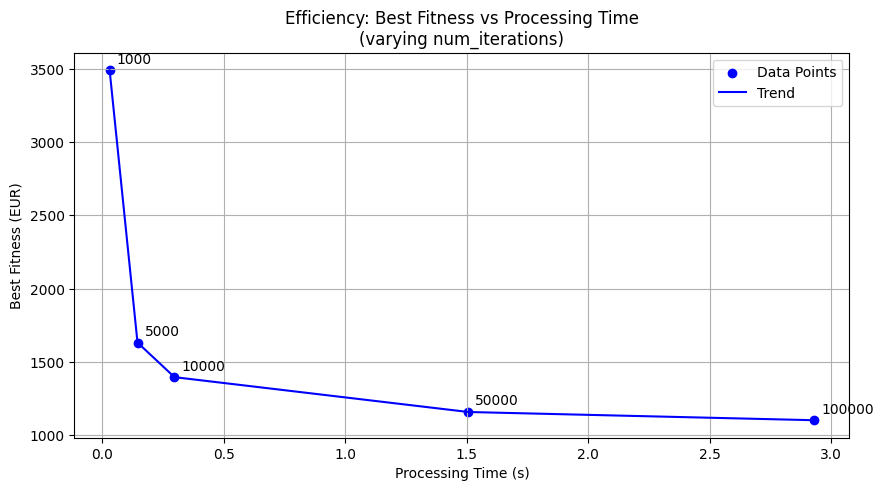

Running efficacy grid search (step_size vs tolerance)...

Best Efficacy Parameters:
Step Size: 0.025
Tolerance: 5e-06
Achieved Fitness: 837.76 EUR


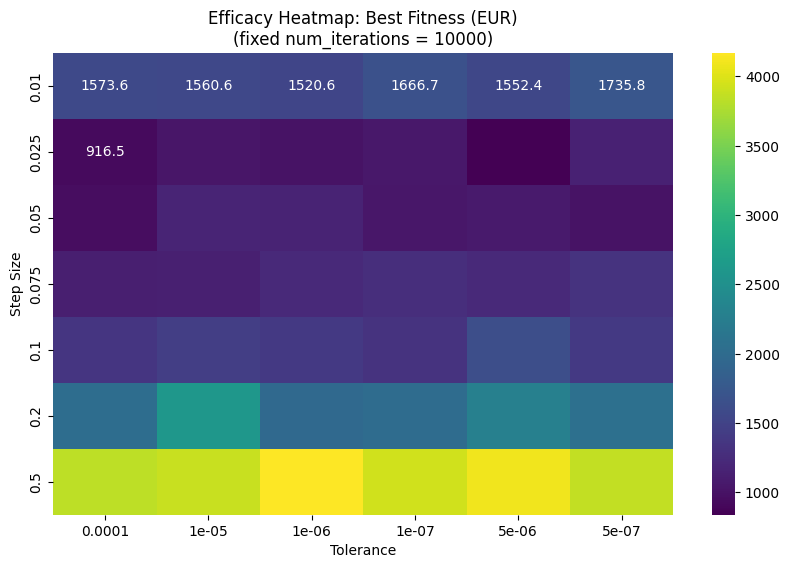

In [19]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ----- Experiment 1: Efficiency Plot Varying num_iterations -----
# Baseline parameters for local search
baseline_step_size = 0.1
baseline_tolerance = 1e-5

# Define a list of num_iterations values to test
num_iterations_list = [1000, 5000, 10000, 50000, 100000]

# Lists to store results
eff_times = []       # Processing time for each run
eff_fitnesses = []   # Best fitness for each run

print("Running Efficiency Experiment (varying num_iterations)...")
for n in num_iterations_list:
    start_time = time.time()
    best_sol, best_fit = local_search(init_solution, num_iterations=n, 
                                      step_size=baseline_step_size, tolerance=baseline_tolerance)
    elapsed = time.time() - start_time
    eff_times.append(elapsed)
    eff_fitnesses.append(best_fit)
    # print(f"num_iterations: {n:>6} | Best Fitness: {best_fit:10.2f} EUR | Time: {elapsed:6.2f} s")

def plot_efficiency(iterations, times, fitnesses):
    """
    Plots an efficiency graph with processing time (x-axis) and best fitness (y-axis)
    connected by a line to show the tendency, and annotates each point with the iteration count.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(times, fitnesses, color='blue', label='Data Points')
    plt.plot(times, fitnesses, color='blue', linestyle='-', label='Trend')
    
    for i, n in enumerate(iterations):
        plt.annotate(str(n), (times[i], fitnesses[i]), textcoords="offset points", xytext=(5,5))
    
    plt.xlabel("Processing Time (s)")
    plt.ylabel("Best Fitness (EUR)")
    plt.title("Efficiency: Best Fitness vs Processing Time\n(varying num_iterations)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficiency results
plot_efficiency(num_iterations_list, eff_times, eff_fitnesses)


# ----- Experiment 2: Efficacy Heatmap over step_size and tolerance -----
# Fix the number of iterations for this experiment
fixed_num_iterations = 10000

# Define grids for step_size and tolerance
step_size_list = [0.01, 0.025,0.05, 0.075, 0.1, 0.2, 0.5]
tolerance_list = [1e-4, 1e-5, 1e-6,1e-7, 5e-6, 5e-7 ]

# Prepare an array to store best fitness for each (step_size, tolerance) pair
heatmap_data = np.zeros((len(step_size_list), len(tolerance_list)))

# Variables to track the best overall parameters
best_overall_fitness = float('inf')
best_step_size = None
best_tolerance = None

# For consistency, use the same initial solution for each grid search run
init_solution_grid = generate_random_solution()

print("Running efficacy grid search (step_size vs tolerance)...")
for i, step in enumerate(step_size_list):
    for j, tol in enumerate(tolerance_list):
        # Run local search with progress disabled (show_progress=False)
        best_sol, best_fit = local_search(init_solution_grid, num_iterations=fixed_num_iterations, 
                                          step_size=step, tolerance=tol)
        heatmap_data[i, j] = best_fit

        # Update the best overall parameters if an improvement is found
        if best_fit < best_overall_fitness:
            best_overall_fitness = best_fit
            best_step_size = step
            best_tolerance = tol

        # print(f"step_size: {step:<6} | tolerance: {tol:<10} | Best Fitness: {best_fit:.2f} EUR")

# Print the best efficacy parameters found
print("\nBest Efficacy Parameters:")
print(f"Step Size: {best_step_size}")
print(f"Tolerance: {best_tolerance}")
print(f"Achieved Fitness: {best_overall_fitness:.2f} EUR")

# Create a heatmap to show the best fitness for each combination
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=tolerance_list, yticklabels=step_size_list)
plt.xlabel("Tolerance")
plt.ylabel("Step Size")
plt.title(f"Efficacy Heatmap: Best Fitness (EUR)\n(fixed num_iterations = {fixed_num_iterations})")
plt.show()


In [24]:
# Perform local search starting from the initial solution with tqdm progress bar
best_sol, best_fit = local_search(init_solution, verbose=True)

print("Local Search Best Fitness:", best_fit)


Local Search Best Fitness: 797.2526920018045


In [4]:
from tqdm import tqdm

def simulated_annealing(initial_solution=generate_random_solution(), num_iterations=50000, initial_temperature=1500, cooling_rate=0.97, step_size=0.025, verbose=False):
    """
    Performs simulated annealing starting from an initial solution to find an improved solution.
    
    -----------------------
    Simulated annealing is an optimization technique inspired by the annealing process in metallurgy.
    It begins with a high "temperature" that allows the algorithm to accept worse solutions with a certain probability,
    thus avoiding getting trapped in local minima. As the temperature decreases according to a cooling schedule,
    the algorithm becomes more conservative and primarily accepts improvements.
    
    In this implementation:
      - Starting from an initial solution, at each iteration a neighbor is generated by applying a small random perturbation.
      - The change in fitness (delta) is computed. If the neighbor has a lower fitness (better solution),
        it is accepted. Otherwise, it may still be accepted with a probability that decreases with delta and the current temperature.
      - The temperature is reduced at every iteration using a cooling rate.
      - The process repeats for a specified number of iterations.
    
    Parameters:
        initial_solution (np.array): The starting solution (1D array) for simulated annealing.
        num_iterations (int): The total number of iterations to perform.
        initial_temperature (float): The starting temperature for the annealing process.
        cooling_rate (float): The factor by which the temperature is multiplied each iteration (e.g., 0.99).
        step_size (float): The magnitude of the random perturbation applied to generate neighbors.
        verbose (bool): If True, display a progress bar using tqdm. Defaults to False.
    
    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.
    """
    # Initialize the current solution and fitness
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)
    
    # Set the best found solution initially to the current solution
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    # Set the initial temperature
    T = initial_temperature

    # Choose the appropriate iterator based on verbosity
    iterator = (tqdm(range(num_iterations), desc="Simulated Annealing") 
                if verbose else range(num_iterations))
    
    for _ in iterator:
        # Generate a neighbor by applying a small random perturbation
        neighbor = current_solution + np.random.uniform(-step_size, step_size, size=current_solution.shape)
        # Ensure the neighbor respects the temperature bounds
        neighbor = np.clip(neighbor, MIN_TEMP, MAX_TEMP)
        
        # Evaluate the fitness of the neighbor
        neighbor_fitness = fitness(neighbor)
        delta = neighbor_fitness - current_fitness
        
        # Decide whether to accept the neighbor
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            current_solution = neighbor
            current_fitness = neighbor_fitness
            
            # Update the best found solution if improved
            if current_fitness < best_fitness:
                best_solution = current_solution.copy()
                best_fitness = current_fitness
        
        # Decrease the temperature
        T *= cooling_rate

    return best_solution.tolist(), best_fitness

# Run simulated annealing with verbose output controlled by the verbose flag
solution, sol_fitness = simulated_annealing(num_iterations=100000, initial_temperature=1000, cooling_rate=0.99, step_size=0.1, verbose=True)

print("Simulated Annealing Best Fitness:", sol_fitness)


Simulated Annealing:  70%|███████   | 70376/100000 [00:02<00:01, 26460.58it/s]C:\Users\Ghiki\AppData\Local\Temp\ipykernel_14072\3943012223.py:59: RuntimeWarning: overflow encountered in scalar divide
  if delta < 0 or np.random.rand() < np.exp(-delta / T):
Simulated Annealing: 100%|██████████| 100000/100000 [00:03<00:00, 26397.74it/s]

Simulated Annealing Best Fitness: 1134.3610543787552


Running Efficiency Experiment (varying num_iterations) for Simulated Annealing...
num_iterations:   1000 | Best Fitness:    4312.79 EUR | Time:   0.03 s
num_iterations:   5000 | Best Fitness:    1853.87 EUR | Time:   0.15 s
num_iterations:  10000 | Best Fitness:    1268.43 EUR | Time:   0.31 s
num_iterations:  50000 | Best Fitness:    1149.21 EUR | Time:   1.61 s


C:\Users\Ghiki\AppData\Local\Temp\ipykernel_17992\4214233485.py:59: RuntimeWarning: overflow encountered in scalar divide
  if delta < 0 or np.random.rand() < np.exp(-delta / T):


num_iterations: 100000 | Best Fitness:    1145.04 EUR | Time:   3.06 s


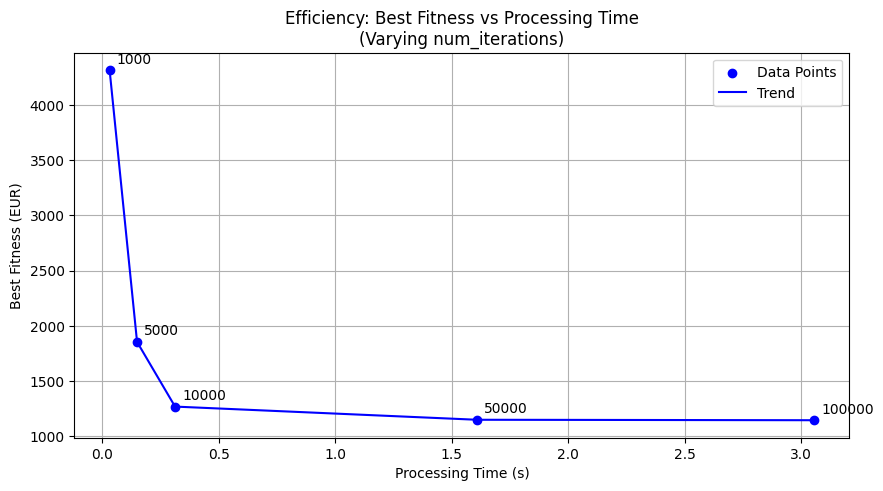

Running 3D Grid Search for Simulated Annealing parameters...

Best Efficacy Parameters for Simulated Annealing:
Initial Temperature: 1500
Cooling Rate: 0.97
Step Size: 0.025
Achieved Fitness: 838.72 EUR


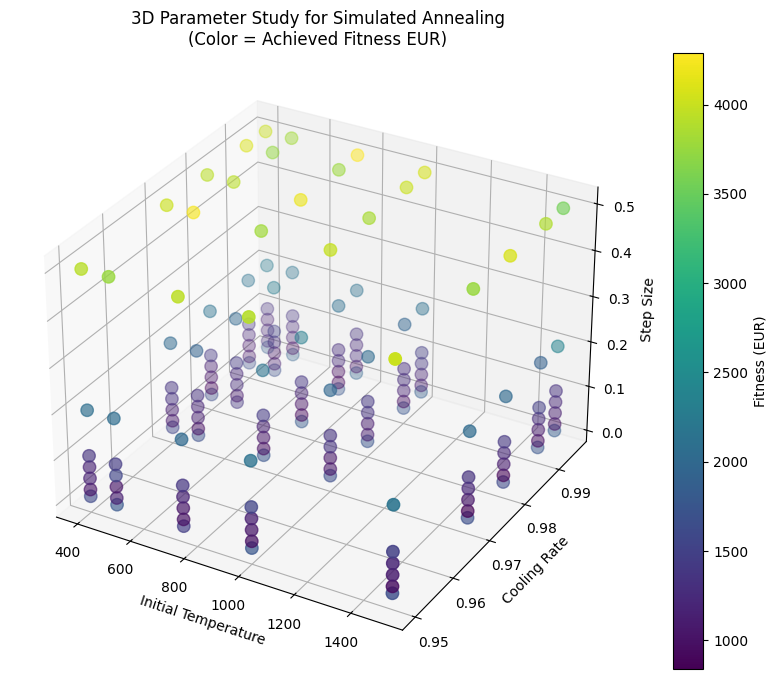

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import matplotlib.cm as cm
from tqdm import tqdm

# ---------------------------
# Experiment 1: Efficiency Study (Varying num_iterations)
# ---------------------------
# Baseline parameters for simulated annealing
baseline_initial_temperature = 1000
baseline_cooling_rate = 0.99
baseline_step_size = 0.1

# Define a list of num_iterations values to test
num_iterations_list = [1000, 5000, 10000, 50000, 100000]

# Lists to store results for efficiency
eff_times = []       # Processing time for each run
eff_fitnesses = []   # Best fitness for each run

# Use the same initial solution for consistency
init_solution = generate_random_solution()

print("Running Efficiency Experiment (varying num_iterations) for Simulated Annealing...")
for n in num_iterations_list:
    start_time = time.time()
    best_sol, best_fit = simulated_annealing(
        init_solution,
        num_iterations=n,
        initial_temperature=baseline_initial_temperature,
        cooling_rate=baseline_cooling_rate,
        step_size=baseline_step_size,
        verbose=False  # Suppress tqdm output
    )
    elapsed = time.time() - start_time
    eff_times.append(elapsed)
    eff_fitnesses.append(best_fit)
    print(f"num_iterations: {n:>6} | Best Fitness: {best_fit:10.2f} EUR | Time: {elapsed:6.2f} s")

def plot_efficiency(iterations, times, fitnesses):
    """
    Plots an efficiency graph with processing time (x-axis) and best fitness (y-axis)
    connected by a line to show the tendency, and annotates each point with the iteration count.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(times, fitnesses, color='blue', label='Data Points')
    plt.plot(times, fitnesses, color='blue', linestyle='-', label='Trend')
    for i, n in enumerate(iterations):
        plt.annotate(str(n), (times[i], fitnesses[i]), textcoords="offset points", xytext=(5,5))
    plt.xlabel("Processing Time (s)")
    plt.ylabel("Best Fitness (EUR)")
    plt.title("Efficiency: Best Fitness vs Processing Time\n(Varying num_iterations)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficiency results
plot_efficiency(num_iterations_list, eff_times, eff_fitnesses)

# ---------------------------
# Experiment 2: Efficacy Study (Grid Search over step_size, cooling_rate, and initial_temperature)
# ---------------------------
# Fix the number of iterations for this experiment
fixed_num_iterations = 10000

# Define grids for step_size and cooling_rate
step_size_list = [0.01,0.025, 0.05, 0.075, 0.1, 0.2, 0.5]
cooling_rate_list = [0.95, 0.97, 0.98, 0.99, 0.995]
# Define a list of initial temperatures to test (each will produce a separate heatmap)
initial_temperature_list = [400,500,750, 1000, 1500]

# Variables to track the overall best parameters
overall_best_fitness = float('inf')
overall_best_params = {}

# Prepare lists to collect 3D data points
init_temps = []
cooling_rates = []
step_sizes = []
fitness_values = []

# For consistency, use the same initial solution for all grid runs
init_solution_grid = generate_random_solution()

print("Running 3D Grid Search for Simulated Annealing parameters...")
# Iterate over all parameter combinations
for init_temp in initial_temperature_list:
    for cooling_rate in cooling_rate_list:
        for step in step_size_list:
            best_sol, best_fit = simulated_annealing(
                init_solution_grid,
                num_iterations=fixed_num_iterations,
                initial_temperature=init_temp,
                cooling_rate=cooling_rate,
                step_size=step,
                verbose=False
            )
            # Store the parameter combination and fitness result
            init_temps.append(init_temp)
            cooling_rates.append(cooling_rate)
            step_sizes.append(step)
            fitness_values.append(best_fit)
            
            # Update overall best parameters if an improvement is found
            if best_fit < overall_best_fitness:
                overall_best_fitness = best_fit
                overall_best_params = {
                    "initial_temperature": init_temp,
                    "cooling_rate": cooling_rate,
                    "step_size": step,
                    "fitness": best_fit
                }
            # Optionally, you can print intermediate results here.
            # print(f"Init Temp: {init_temp}, Cooling Rate: {cooling_rate}, Step Size: {step} => Fitness: {best_fit:.2f} EUR")

# Print the overall best parameter combination found
print("\nBest Efficacy Parameters for Simulated Annealing:")
print(f"Initial Temperature: {overall_best_params['initial_temperature']}")
print(f"Cooling Rate: {overall_best_params['cooling_rate']}")
print(f"Step Size: {overall_best_params['step_size']}")
print(f"Achieved Fitness: {overall_best_params['fitness']:.2f} EUR")

# --- 3D Plot: Create a scatter plot with the three parameters and fitness as color ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot; color each point based on its fitness value
sc = ax.scatter(init_temps, cooling_rates, step_sizes, c=fitness_values, cmap='viridis', s=80)
ax.set_xlabel("Initial Temperature")
ax.set_ylabel("Cooling Rate")
ax.set_zlabel("Step Size")
ax.set_title("3D Parameter Study for Simulated Annealing\n(Color = Achieved Fitness EUR)")
fig.colorbar(sc, ax=ax, label="Fitness (EUR)")
plt.show()


In [10]:
solution, sol_fitness = simulated_annealing(init_solution,verbose=True)

print("Simulated Annealing Best Fitness:", sol_fitness)

Simulated Annealing:  70%|███████   | 70258/100000 [00:02<00:00, 31730.57it/s]C:\Users\Ghiki\AppData\Local\Temp\ipykernel_17992\4214233485.py:59: RuntimeWarning: overflow encountered in scalar divide
  if delta < 0 or np.random.rand() < np.exp(-delta / T):
Simulated Annealing: 100%|██████████| 100000/100000 [00:03<00:00, 31405.83it/s]

Simulated Annealing Best Fitness: 1245.2886783355639


In [5]:
def tabu_search(initial_solution=generate_random_solution(), max_iterations=10000, tabu_list_size=100, neighborhood_size=50, step_size=0.05, verbose=False):
    """
    Perform a Tabu Search starting from an initial solution to find an improved solution.
    
    -----------------------
    Tabu Search is a metaheuristic that iteratively moves from one solution to a neighboring solution.
    Unlike local search, it uses memory structures (called the tabu list) to store recently visited solutions or moves
    to avoid cycling and to encourage exploration of new areas in the search space.
    
    In this implementation:
      - The search starts with an initial solution.
      - At each iteration, a set of candidate neighbors is generated by applying random perturbations to the current solution.
      - The best candidate that is not in the tabu list (or that meets an aspiration criterion) is selected as the new solution.
      - The tabu list is updated with the move (or a representation of the solution) to prevent immediate revisiting.
      - This process continues for a maximum number of iterations, and the best solution encountered is returned.
    
    Parameters:
        initial_solution (np.array): The starting solution (1D array).
        max_iterations (int): Maximum number of iterations to perform.
        tabu_list_size (int): Maximum size of the tabu list.
        neighborhood_size (int): Number of neighbor solutions to generate at each iteration.
        step_size (float): The magnitude of the random perturbation applied to generate neighbors.
        verbose (bool): If True, display a progress bar using tqdm. Defaults to False.
    
    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.
    """
    # Helper: a simple representation of a solution for tabu purposes.
    # We round to 2 decimals to reduce sensitivity.
    def solution_repr(sol):
        return tuple(np.round(sol, 2))
    
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    tabu_list = []  # List of solution representations
    
    # Choose the iterator based on the verbose flag.
    iterator = range(max_iterations)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(range(max_iterations), desc="Tabu Search")
    
    for _ in iterator:
        neighbors = []
        # Generate candidate neighbors
        for _ in range(neighborhood_size):
            # Create a neighbor by adding a random perturbation to the current solution
            neighbor = current_solution + np.random.uniform(-step_size, step_size, size=current_solution.shape)
            # Clip to the allowed bounds
            neighbor = np.clip(neighbor, MIN_TEMP, MAX_TEMP)
            neighbors.append(neighbor)
        
        # Evaluate the fitness for each neighbor
        neighbor_fitnesses = [fitness(neighbor) for neighbor in neighbors]
        
        # Select the best neighbor that is not in the tabu list
        best_neighbor_index = None
        best_neighbor_fitness = float('inf')
        for idx, (neighbor, fit_val) in enumerate(zip(neighbors, neighbor_fitnesses)):
            rep = solution_repr(neighbor)
            if rep in tabu_list:
                continue  # Skip tabu solutions
            if fit_val < best_neighbor_fitness:
                best_neighbor_fitness = fit_val
                best_neighbor_index = idx
        
        # If all neighbors are tabu, select the best neighbor regardless of tabu status.
        if best_neighbor_index is None:
            best_neighbor_index = np.argmin(neighbor_fitnesses)
            best_neighbor_fitness = neighbor_fitnesses[best_neighbor_index]
        
        # Update current solution to the best candidate neighbor
        current_solution = neighbors[best_neighbor_index]
        current_fitness = best_neighbor_fitness
        
        # Add the new solution to the tabu list
        tabu_list.append(solution_repr(current_solution))
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)  # Remove the oldest entry
        
        # Update the overall best solution if improved
        if current_fitness < best_fitness:
            best_solution = current_solution.copy()
            best_fitness = current_fitness

    return best_solution.tolist(), best_fitness

    
# Run Tabu Search with specified parameters and verbose output
best_sol, best_fit = tabu_search(init_solution, max_iterations=10000, tabu_list_size=50, neighborhood_size=20, step_size=0.1, verbose=True)

print("Tabu Search Best Fitness:", best_fit)


Tabu Search: 100%|██████████| 10000/10000 [00:08<00:00, 1179.01it/s]

Tabu Search Best Fitness: 1456.4254918429579


Running Efficiency Experiment (varying max_iterations) for Tabu Search...
max_iterations:   1000 | Best Fitness:    1507.19 EUR | Time:   0.76 s
max_iterations:   5000 | Best Fitness:    1437.84 EUR | Time:   3.74 s
max_iterations:  10000 | Best Fitness:    1452.96 EUR | Time:   7.51 s
max_iterations:  50000 | Best Fitness:    1432.64 EUR | Time:  37.20 s
max_iterations: 100000 | Best Fitness:    1430.77 EUR | Time:  74.77 s


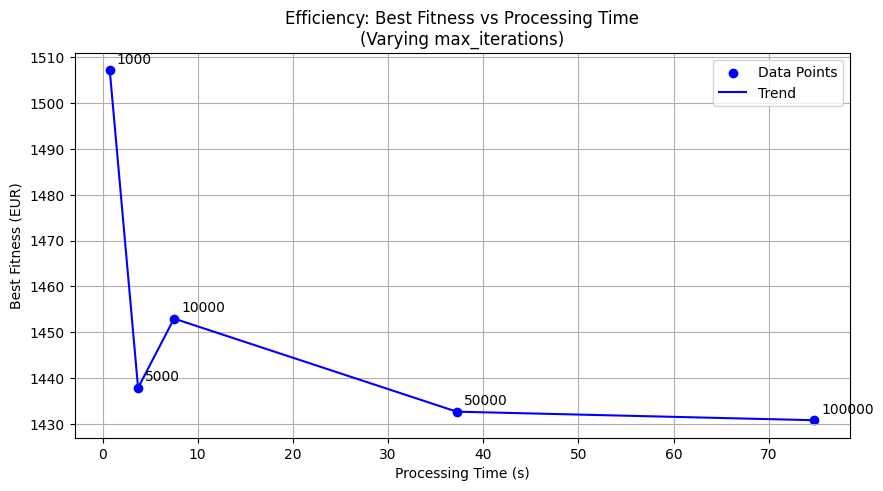


Running Efficacy Grid Search for Tabu Search parameters...

Best Efficacy Parameters for Tabu Search:
Max Iterations: 1000
Tabu List Size: 100
Neighborhood Size: 50
Step Size: 0.05
Achieved Fitness: 948.50 EUR


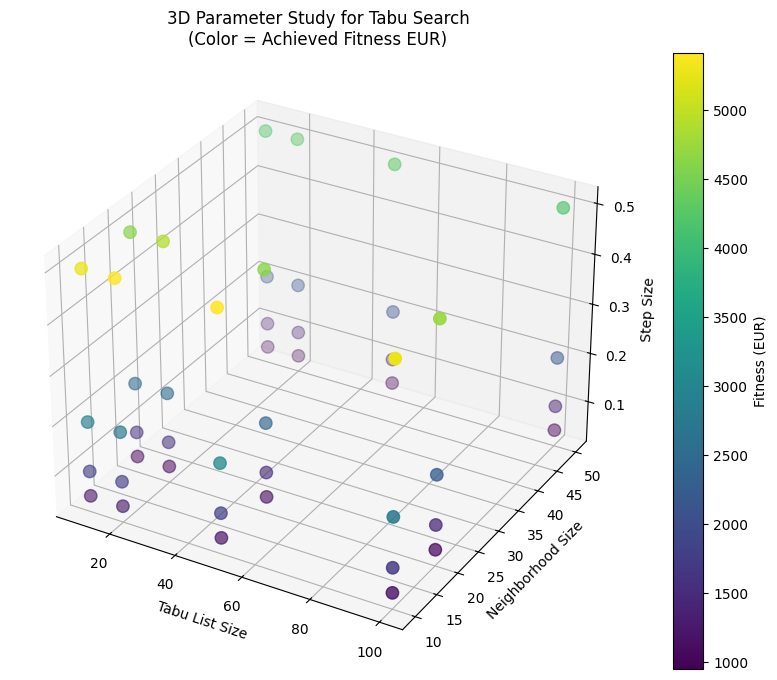

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import matplotlib.cm as cm

# ---------------------------
# Experiment 1: Efficiency Study (Varying max_iterations)
# ---------------------------
# Baseline parameters for Tabu Search
baseline_tabu_list_size = 50
baseline_neighborhood_size = 20
baseline_step_size = 0.1

# Define a list of max_iterations values to test
max_iterations_list = [1000, 5000, 10000, 50000, 100000]

# Lists to store results for efficiency
eff_times = []       # Processing time (s) for each run
eff_fitnesses = []   # Best fitness for each run

# Use the same initial solution for consistency
init_solution = generate_random_solution()

print("Running Efficiency Experiment (varying max_iterations) for Tabu Search...")
for n in max_iterations_list:
    start_time = time.time()
    best_sol, best_fit = tabu_search(
        init_solution,
        max_iterations=n,
        tabu_list_size=baseline_tabu_list_size,
        neighborhood_size=baseline_neighborhood_size,
        step_size=baseline_step_size,
        verbose=False  # no progress bar
    )
    elapsed = time.time() - start_time
    eff_times.append(elapsed)
    eff_fitnesses.append(best_fit)
    print(f"max_iterations: {n:>6} | Best Fitness: {best_fit:10.2f} EUR | Time: {elapsed:6.2f} s")

def plot_efficiency(iterations, times, fitnesses):
    """
    Plots an efficiency graph with processing time (x-axis) and best fitness (y-axis)
    connected by a line to show the trend, and annotates each point with the iteration count.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(times, fitnesses, color='blue', label='Data Points')
    plt.plot(times, fitnesses, color='blue', linestyle='-', label='Trend')
    for i, n in enumerate(iterations):
        plt.annotate(str(n), (times[i], fitnesses[i]), textcoords="offset points", xytext=(5,5))
    plt.xlabel("Processing Time (s)")
    plt.ylabel("Best Fitness (EUR)")
    plt.title("Efficiency: Best Fitness vs Processing Time\n(Varying max_iterations)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficiency results
plot_efficiency(max_iterations_list, eff_times, eff_fitnesses)


# ---------------------------
# Experiment 2: Efficacy Study (Grid Search over Tabu Search Parameters)
# ---------------------------
# Fix the number of iterations for the grid search experiment
fixed_max_iterations = 1000

# Define grids for the three parameters
tabu_list_size_list = [10, 20, 50, 100]
neighborhood_size_list = [10, 20, 50]
step_size_list = [0.05, 0.1, 0.2, 0.5]

# Variables to track the overall best parameters
overall_best_fitness = float('inf')
overall_best_params = {}

# Prepare lists to collect 3D data points for plotting
tabu_sizes = []
neighborhood_sizes = []
step_sizes_plot = []  # renamed for clarity in plotting
fitness_values = []

# For consistency, use the same initial solution for all grid runs
init_solution_grid = generate_random_solution()

print("\nRunning Efficacy Grid Search for Tabu Search parameters...")
for tabu_size in tabu_list_size_list:
    for neigh_size in neighborhood_size_list:
        for step in step_size_list:
            best_sol, best_fit = tabu_search(
                init_solution_grid,
                max_iterations=fixed_max_iterations,
                tabu_list_size=tabu_size,
                neighborhood_size=neigh_size,
                step_size=step,
                verbose=False
            )
            # Store the parameter combination and fitness result
            tabu_sizes.append(tabu_size)
            neighborhood_sizes.append(neigh_size)
            step_sizes_plot.append(step)
            fitness_values.append(best_fit)
            
            # Update overall best parameters if improved
            if best_fit < overall_best_fitness:
                overall_best_fitness = best_fit
                overall_best_params = {
                    "max_iterations": fixed_max_iterations,
                    "tabu_list_size": tabu_size,
                    "neighborhood_size": neigh_size,
                    "step_size": step,
                    "fitness": best_fit
                }
            # Optionally, you can print intermediate results.
            # print(f"Tabu Size: {tabu_size}, Neighborhood Size: {neigh_size}, Step Size: {step} => Fitness: {best_fit:.2f} EUR")

# Print the overall best parameter combination found
print("\nBest Efficacy Parameters for Tabu Search:")
print(f"Max Iterations: {overall_best_params['max_iterations']}")
print(f"Tabu List Size: {overall_best_params['tabu_list_size']}")
print(f"Neighborhood Size: {overall_best_params['neighborhood_size']}")
print(f"Step Size: {overall_best_params['step_size']}")
print(f"Achieved Fitness: {overall_best_params['fitness']:.2f} EUR")

# --- 3D Plot: Create a scatter plot with the three parameters and fitness as color ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot where:
#   x-axis: Tabu List Size
#   y-axis: Neighborhood Size
#   z-axis: Step Size
# Color represents the achieved fitness value.
sc = ax.scatter(tabu_sizes, neighborhood_sizes, step_sizes_plot, c=fitness_values, cmap='viridis', s=80)
ax.set_xlabel("Tabu List Size")
ax.set_ylabel("Neighborhood Size")
ax.set_zlabel("Step Size")
ax.set_title("3D Parameter Study for Tabu Search\n(Color = Achieved Fitness EUR)")
fig.colorbar(sc, ax=ax, label="Fitness (EUR)")
plt.show()


In [20]:
# Run Tabu Search with specified parameters and verbose output
best_sol, best_fit = tabu_search(init_solution, verbose=True)

print("Tabu Search Best Fitness:", best_fit)

Tabu Search: 100%|██████████| 10000/10000 [00:07<00:00, 1286.14it/s]

Tabu Search Best Fitness: 1464.3180791465845


In [6]:
def variable_neighborhood_search(initial_solution, max_iterations=10000, neighborhoods=[0.01, 0.05, 0.1, 0.2], verbose=False):
    """
    Perform Variable Neighborhood Search (VNS) starting from an initial solution to find an improved solution.
    
    -----------------------
    Variable Neighborhood Search (VNS) is a metaheuristic that systematically changes the neighborhood structures 
    during the search process to escape local optima. In this implementation, different neighborhoods are 
    defined by different step sizes for perturbing the current solution.
    
    The algorithm proceeds as follows:
      1. Start with an initial solution and evaluate its fitness.
      2. For a maximum number of iterations:
          a. Set the neighborhood index k = 0.
          b. While k is less than the total number of neighborhood structures:
              i. Generate a neighbor solution by perturbing the current solution with a step size defined 
                 by the k-th neighborhood.
             ii. If the neighbor has a better fitness (i.e., lower energy cost) than the current solution, 
                 update the current solution, reset k to 0, and break out of the inner loop.
            iii. Otherwise, increment k to try a different neighborhood.
      3. Return the best solution and its fitness after the maximum iterations or if no improvement is found.
    
    Parameters:
        initial_solution (np.array): The starting solution (1D array) for VNS.
        max_iterations (int): Maximum number of iterations to perform.
        neighborhoods (list of float): A list of step sizes defining the different neighborhood structures.
        verbose (bool): If True, display a progress bar using tqdm. Defaults to False.
    
    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.
    """
    # Initialize current solution and fitness
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)
    
    # Set the overall best solution
    best_solution = current_solution.copy()
    best_fitness = current_fitness

    # Choose the iterator based on the verbose flag.
    iterator = (tqdm(range(max_iterations), desc="VNS") if verbose else range(max_iterations))
    
    for _ in iterator:
        # Set the neighborhood index k = 0 at the start of each iteration.
        k = 0
        improvement_found = False
        
        while k < len(neighborhoods):
            # The current neighborhood is defined by the step size neighborhoods[k]
            step = neighborhoods[k]
            # Generate a neighbor by perturbing the current solution
            neighbor = current_solution + np.random.uniform(-step, step, size=current_solution.shape)
            # Ensure the neighbor respects the allowed bounds
            neighbor = np.clip(neighbor, MIN_TEMP, MAX_TEMP)
            neighbor_fitness = fitness(neighbor)
            
            # If an improvement is found, update and reset the neighborhood index.
            if neighbor_fitness < current_fitness:
                current_solution = neighbor
                current_fitness = neighbor_fitness
                # Update overall best solution if improved
                if current_fitness < best_fitness:
                    best_solution = current_solution.copy()
                    best_fitness = current_fitness
                k = 0
                improvement_found = True
                break  # Exit the inner loop and restart with k=0
            else:
                # No improvement in the current neighborhood, try the next neighborhood
                k += 1
        
        # If no improvement is found in any neighborhood, we may continue to the next iteration.
        # (Alternatively, one may consider terminating if no improvement is found.)
        if not improvement_found:
            continue

    return best_solution.tolist(), best_fitness

    
# Run VNS with verbose output controlled by the verbose flag
best_sol, best_fit = variable_neighborhood_search(init_solution, max_iterations=10000, 
                                                    neighborhoods=[0.01, 0.05, 0.1, 0.2], verbose=True)

print("Variable Neighborhood Search Best Fitness:", best_fit)


VNS: 100%|██████████| 10000/10000 [00:01<00:00, 8372.38it/s]

Variable Neighborhood Search Best Fitness: 948.2289218910037


In [7]:
def improved_variable_neighborhood_search(initial_solution, 
                                          max_iterations=50000, 
                                          neighborhoods=[0.01, 0.05, 0.1, 0.2],
                                          local_search_iterations=100,
                                          stagnation_threshold=750,
                                          diversification_strength=0.5,
                                          memory_threshold=7,
                                          verbose=False):
    """
    Perform an improved Variable Neighborhood Search (VNS) to find a high-quality solution.

    -----------------------
    This improved VNS algorithm combines several advanced strategies to enhance the search:
    
    1. **Variable Neighborhood Structure:**  
       The search iterates through a list of neighborhoods, each defined by a different step size.
       For each neighborhood, a candidate neighbor is generated by perturbing the current solution.
    
    2. **Local Search Intensification:**  
       When a candidate neighbor exhibits an improved fitness, a short local search is triggered
       from that neighbor to intensify the search in that promising region. This helps refine the solution
       beyond the immediate perturbation.
    
    3. **Memory-Based Strategy:**  
       The algorithm maintains a memory (dictionary) of rounded solution representations, tracking how 
       frequently similar solutions have been visited. If a solution has been visited more than a specified 
       threshold, it is skipped, which helps avoid redundant exploration of the same region.
    
    4. **Diversification via Stagnation Handling:**  
       If no improvement is found for a specified number of iterations (stagnation threshold), a 
       diversification step is executed. This involves strongly perturbing the best solution found so far 
       (using a higher diversification strength) to escape local optima and explore new regions of the search space.
    
    The algorithm continues iteratively updating the current solution and resetting the neighborhood index 
    when improvements are found. It returns the best solution discovered along with its fitness.
    
    Parameters:
        initial_solution (np.array): The starting solution (1D array) for VNS.
        max_iterations (int): Maximum number of iterations to perform.
        neighborhoods (list of float): List of step sizes defining different neighborhood structures.
        local_search_iterations (int): Number of iterations to run a short local search when an improvement is found.
        stagnation_threshold (int): Number of iterations with no improvement before triggering diversification.
        diversification_strength (float): The step size used to strongly perturb the best solution during diversification.
        memory_threshold (int): Maximum allowed visits for a solution representation before it is skipped.
        verbose (bool): If True, display a progress bar using tqdm.
    
    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.
    """
    # Helper to create a simplified representation of a solution (rounded to 2 decimals)
    def solution_repr(sol):
        return tuple(np.round(sol, 2))
    
    # Assume local_search is defined elsewhere.
    # It should be of the form: local_search(initial_solution, num_iterations, step_size, tolerance, verbose)
    # For intensification, we can run a short local search.
    
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    # Memory: dictionary mapping solution_repr -> count of visits
    memory = {}
    
    iterations_without_improvement = 0

    iterator = range(max_iterations)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(range(max_iterations), desc="Improved VNS")
    
    for it in iterator:
        k = 0
        improvement_found = False
        
        # Check stagnation: if too many iterations with no improvement, diversify
        if iterations_without_improvement >= stagnation_threshold:
            # Diversification: randomly perturb the best solution strongly
            current_solution = best_solution + np.random.uniform(-diversification_strength, diversification_strength, 
                                                                   size=best_solution.shape)
            current_solution = np.clip(current_solution, MIN_TEMP, MAX_TEMP)
            current_fitness = fitness(current_solution)
            iterations_without_improvement = 0  # Reset stagnation counter
        
        # Explore neighborhoods in order
        while k < len(neighborhoods):
            step = neighborhoods[k]
            neighbor = current_solution + np.random.uniform(-step, step, size=current_solution.shape)
            neighbor = np.clip(neighbor, MIN_TEMP, MAX_TEMP)
            neighbor_fitness = fitness(neighbor)
            
            rep = solution_repr(neighbor)
            # Check memory: if we've visited a similar solution too many times, skip this neighbor.
            if memory.get(rep, 0) >= memory_threshold:
                k += 1
                continue
            
            # If improvement is found in the neighborhood:
            if neighbor_fitness < current_fitness:
                # Intensification: run a short local search starting from the neighbor.
                try:
                    # We assume local_search returns (improved_solution, improved_fitness)
                    improved_sol, improved_fit = local_search(neighbor, num_iterations=local_search_iterations, 
                                                              step_size=step, tolerance=1e-5, verbose=False)
                except Exception:
                    # If local_search is not available, simply use the neighbor.
                    improved_sol, improved_fit = neighbor, neighbor_fitness
                
                if improved_fit < current_fitness:
                    current_solution = improved_sol
                    current_fitness = improved_fit
                    # Update memory count
                    memory[solution_repr(current_solution)] = memory.get(solution_repr(current_solution), 0) + 1
                    
                    # Update overall best if improved
                    if current_fitness < best_fitness:
                        best_solution = current_solution.copy()
                        best_fitness = current_fitness
                        iterations_without_improvement = 0  # reset stagnation counter
                    # Reset neighborhood index after improvement
                    k = 0
                    improvement_found = True
                    break
            # No improvement in this neighborhood; try next.
            k += 1
        
        if not improvement_found:
            iterations_without_improvement += 1

    return best_solution.tolist(), best_fitness

    
best_sol, best_fit = improved_variable_neighborhood_search(init_solution, 
                                                        max_iterations=10000,
                                                        neighborhoods=[0.01, 0.05, 0.1, 0.2],
                                                        local_search_iterations=100,
                                                        stagnation_threshold=500,
                                                        diversification_strength=0.5,
                                                        memory_threshold=5,
                                                        verbose=True)

print("Improved VNS Best Fitness:", best_fit)


Improved VNS: 100%|██████████| 10000/10000 [00:02<00:00, 3494.20it/s]

Improved VNS Best Fitness: 652.5518976136727


Running Efficiency Experiment (varying max_iterations) for Improved VNS...
max_iterations:   1000 | Best Fitness:    1370.35 EUR | Time:   0.47 s
max_iterations:   5000 | Best Fitness:     852.99 EUR | Time:   1.45 s
max_iterations:  10000 | Best Fitness:     693.92 EUR | Time:   2.73 s
max_iterations:  50000 | Best Fitness:     626.69 EUR | Time:  17.86 s
max_iterations: 100000 | Best Fitness:     672.10 EUR | Time:  36.59 s


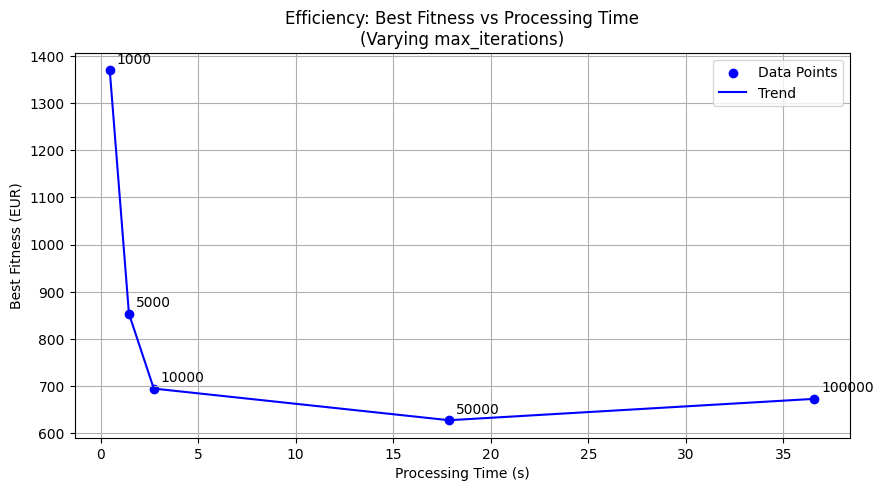


Running Efficacy Grid Search for Improved VNS parameters...

Best Efficacy Parameters for Improved VNS:
Max Iterations: 1000
Stagnation Threshold: 750
Diversification Strength: 0.5
Memory Threshold: 7
Achieved Fitness: 868.66 EUR


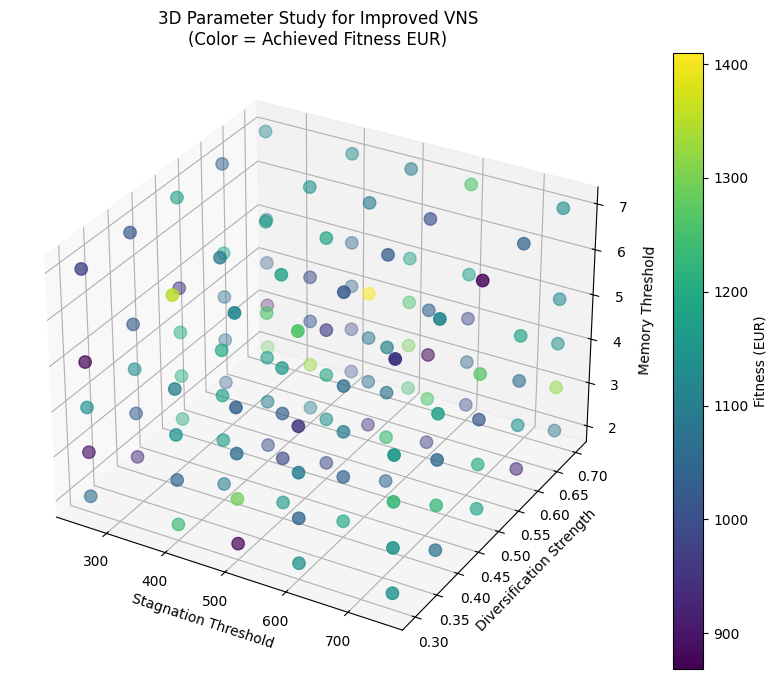

In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# ---------------------------
# Experiment 1: Efficiency Study (Varying max_iterations)
# ---------------------------
# Baseline parameters for improved VNS
baseline_neighborhoods = [0.01, 0.05, 0.1, 0.2]
baseline_local_search_iterations = 100
baseline_stagnation_threshold = 500
baseline_diversification_strength = 0.5
baseline_memory_threshold = 5

# Define a list of max_iterations values to test
max_iterations_list = [1000, 5000, 10000, 50000, 100000]

# Lists to store efficiency results
eff_times = []       # Processing time (s) for each run
eff_fitnesses = []   # Best fitness for each run

# Use the same initial solution for consistency
init_solution = generate_random_solution()

print("Running Efficiency Experiment (varying max_iterations) for Improved VNS...")
for n in max_iterations_list:
    start_time = time.time()
    best_sol, best_fit = improved_variable_neighborhood_search(
        init_solution,
        max_iterations=n,
        neighborhoods=baseline_neighborhoods,
        local_search_iterations=baseline_local_search_iterations,
        stagnation_threshold=baseline_stagnation_threshold,
        diversification_strength=baseline_diversification_strength,
        memory_threshold=baseline_memory_threshold,
        verbose=False
    )
    elapsed = time.time() - start_time
    eff_times.append(elapsed)
    eff_fitnesses.append(best_fit)
    print(f"max_iterations: {n:>6} | Best Fitness: {best_fit:10.2f} EUR | Time: {elapsed:6.2f} s")

def plot_efficiency(iterations, times, fitnesses):
    """
    Plots an efficiency graph with processing time (x-axis) and best fitness (y-axis)
    connected by a line to show the tendency. Each point is annotated with the iteration count.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(times, fitnesses, color='blue', label='Data Points')
    plt.plot(times, fitnesses, color='blue', linestyle='-', label='Trend')
    for i, n in enumerate(iterations):
        plt.annotate(str(n), (times[i], fitnesses[i]), textcoords="offset points", xytext=(5,5))
    plt.xlabel("Processing Time (s)")
    plt.ylabel("Best Fitness (EUR)")
    plt.title("Efficiency: Best Fitness vs Processing Time\n(Varying max_iterations)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot efficiency results
plot_efficiency(max_iterations_list, eff_times, eff_fitnesses)


# ---------------------------
# Experiment 2: Efficacy Study (Grid Search over Improved VNS Parameters)
# ---------------------------
# Fix the number of iterations for the grid search experiment
fixed_max_iterations = 1000

# Define grids for the three parameters to study:
# 1. Stagnation Threshold
stagnation_threshold_list = [250,400, 500, 600,750]
# 2. Diversification Strength
diversification_strength_list = [0.3,0.4, 0.5,0.6, 0.7]
# 3. Memory Threshold
memory_threshold_list = [2,3,4, 5, 7]

# Variables to track the overall best parameters
overall_best_fitness = float('inf')
overall_best_params = {}

# Prepare lists to collect 3D data points for plotting
stagnation_values = []
diversification_values = []
memory_values = []
fitness_values = []

# Use the same initial solution for all grid runs
init_solution_grid = generate_random_solution()

print("\nRunning Efficacy Grid Search for Improved VNS parameters...")
for stag in stagnation_threshold_list:
    for div in diversification_strength_list:
        for mem in memory_threshold_list:
            best_sol, best_fit = improved_variable_neighborhood_search(
                init_solution_grid,
                max_iterations=fixed_max_iterations,
                neighborhoods=baseline_neighborhoods,
                local_search_iterations=baseline_local_search_iterations,
                stagnation_threshold=stag,
                diversification_strength=div,
                memory_threshold=mem,
                verbose=False
            )
            # Record the parameter combination and fitness result
            stagnation_values.append(stag)
            diversification_values.append(div)
            memory_values.append(mem)
            fitness_values.append(best_fit)
            
            # Update overall best parameters if an improvement is found
            if best_fit < overall_best_fitness:
                overall_best_fitness = best_fit
                overall_best_params = {
                    "max_iterations": fixed_max_iterations,
                    "stagnation_threshold": stag,
                    "diversification_strength": div,
                    "memory_threshold": mem,
                    "fitness": best_fit
                }
            # Optionally, print intermediate results:
            # print(f"Stag: {stag}, Div: {div}, Mem: {mem} => Fitness: {best_fit:.2f} EUR")

# Print the overall best parameter combination found
print("\nBest Efficacy Parameters for Improved VNS:")
print(f"Max Iterations: {overall_best_params['max_iterations']}")
print(f"Stagnation Threshold: {overall_best_params['stagnation_threshold']}")
print(f"Diversification Strength: {overall_best_params['diversification_strength']}")
print(f"Memory Threshold: {overall_best_params['memory_threshold']}")
print(f"Achieved Fitness: {overall_best_params['fitness']:.2f} EUR")

# --- 3D Plot: Create a scatter plot for the grid search ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter where:
#   x-axis: Stagnation Threshold
#   y-axis: Diversification Strength
#   z-axis: Memory Threshold
sc = ax.scatter(stagnation_values, diversification_values, memory_values, 
                c=fitness_values, cmap='viridis', s=80)
ax.set_xlabel("Stagnation Threshold")
ax.set_ylabel("Diversification Strength")
ax.set_zlabel("Memory Threshold")
ax.set_title("3D Parameter Study for Improved VNS\n(Color = Achieved Fitness EUR)")
fig.colorbar(sc, ax=ax, label="Fitness (EUR)")
plt.show()


In [17]:
best_sol, best_fit = improved_variable_neighborhood_search(init_solution, verbose=True)

print("Improved VNS Best Fitness:", best_fit)

Improved VNS: 100%|██████████| 50000/50000 [00:15<00:00, 3179.25it/s]

Improved VNS Best Fitness: 626.993765164089


In [9]:
def compare_methods():
    """
    Compares the following optimization methods using the same initial solution:
      - Random Search
      - Local Search
      - Simulated Annealing
      - Tabu Search
      - Variable Neighborhood Search (VNS)
      - Improved Variable Neighborhood Search (Improved VNS)
    
    For each method, the function records:
      - Execution time (in seconds)
      - Best fitness (i.e., total energy cost in EUR)
      - The corresponding solution (not printed in full)
    
    The results are printed in a summary table for easy comparison.
    
    Returns:
        dict: A dictionary mapping method names to a tuple (execution_time, best_fitness, solution)
    """
    import time
    
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)

    methods = {}
    # Generate a common initial solution for all methods
    initial_solution = generate_random_solution()

    # -----------------------
    # Random Search
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    rs_solution, rs_fitness = random_search()
    rs_time = time.time() - start
    methods["Random Search"] = (rs_time, rs_fitness, rs_solution)

    # -----------------------
    # Local Search
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    ls_solution, ls_fitness = local_search(initial_solution)
    ls_time = time.time() - start
    methods["Local Search"] = (ls_time, ls_fitness, ls_solution)

    # -----------------------
    # Simulated Annealing
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    sa_solution, sa_fitness = simulated_annealing(initial_solution)
    sa_time = time.time() - start
    methods["Simulated Annealing"] = (sa_time, sa_fitness, sa_solution)

    # -----------------------
    # Tabu Search
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    ts_solution, ts_fitness = tabu_search(initial_solution)
    ts_time = time.time() - start
    methods["Tabu Search"] = (ts_time, ts_fitness, ts_solution)

    # -----------------------
    # Variable Neighborhood Search (VNS)
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    vns_solution, vns_fitness = variable_neighborhood_search(initial_solution)
    vns_time = time.time() - start
    methods["VNS"] = (vns_time, vns_fitness, vns_solution)

    # -----------------------
    # Improved VNS
    # -----------------------
    # reset seed
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    start = time.time()
    ivns_solution, ivns_fitness = improved_variable_neighborhood_search(
        initial_solution,
    )
    ivns_time = time.time() - start
    methods["Improved VNS"] = (ivns_time, ivns_fitness, ivns_solution)

    # -----------------------
    # Print Summary Table
    # -----------------------
    
    print("\nComparison of Optimization Methods:")
    print("{:<25} {:>10} {:>20}".format("Method", "Time (s)", "Best Fitness (EUR)"))
    print("-" * 60)
    for method, (exec_time, fitness_val, sol) in methods.items():
        print("{:<25} {:>10.2f} {:>20.2f}".format(method, exec_time, fitness_val))
    
    return methods

# Example usage:
if __name__ == "__main__":
    compare_methods()


C:\Users\Ghiki\AppData\Local\Temp\ipykernel_14072\3943012223.py:59: RuntimeWarning: overflow encountered in scalar divide
  if delta < 0 or np.random.rand() < np.exp(-delta / T):



Comparison of Optimization Methods:
Method                      Time (s)   Best Fitness (EUR)
------------------------------------------------------------
Random Search                   2.51              7245.93
Local Search                    1.60               799.79
Simulated Annealing             1.68               802.49
Tabu Search                    20.19               916.93
VNS                             1.12               939.82
Improved VNS                   15.32               663.95
